In [93]:
import re
import random
import pandas as pd
import hashlib

In [94]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [95]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Powershell,110.080369,5.241922,21
"CDK Global Ransomeware, June 2024",171.655677,28.609280,6
Finance Junk,233.848304,29.231038,8
Azure OpenAI,295.098057,98.366019,3
Dataverse Queries,400.458984,100.114746,4
Azure AI Foundry,455.642464,30.376164,15
Dataverse Plugins,691.563922,98.794846,7
AKS,706.719062,88.339883,8
pandas,737.643580,92.205448,8
Conditional Access,751.841627,107.405947,7


# Histogram

25875.21


<Axes: >

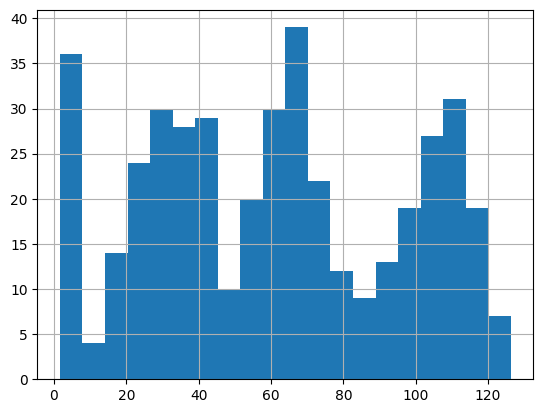

In [96]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [97]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [98]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [99]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [100]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [101]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [102]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [103]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [104]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n
existing_cards['age'] *= -1
existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 423


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
45,DNS,• DNS Amplification Attack:\nA type of DDoS at...,d965fd19e831d6c010bbfa0990500648,-107.359072,64.679004,107.359072,1616.975088,0.002192,0,0
46,DNS,Dynamic Updates\nA DNS feature that allows DNS...,96874ab58c02c6995b4ce577dc1a342f,-86.011621,64.679004,107.359072,1616.975088,0.002192,1,0
47,DNS,Split-Brain DNS\nA DNS configuration strategy ...,2abb43d2621dde153c1448642eaf9021,-76.260771,64.679004,107.359072,1616.975088,0.002192,2,0
15,Email Auth and Security,HELO/EHLO\n\nSMTP commands used by a mail serv...,dff0749374b2467bb430e0743e569254,-48.117666,37.953422,48.117666,834.975279,0.003158,0,0
95,Email Auth and Security,p=none\n\nA DMARC policy action.\nRequests no ...,98ed919f7e08cbf83347817d193116c3,-44.607061,37.953422,48.117666,834.975279,0.003158,1,0
16,Email Auth and Security,MUA (Mail User Agent)\n\nAn email client used ...,728b4872797d6311a0966fa924d6341d,-43.592448,37.953422,48.117666,834.975279,0.003158,2,0
66,MS Identity Platform,OpenID Connect versus SAML: The platform uses ...,44b237b8e558e4cc0f48efc03675f0a0,-118.027523,108.987888,118.027523,1198.866769,0.040634,0,0
67,MS Identity Platform,URIs for certain apps:\n○ Apps that use embedd...,af75a6029c7b258a77de1b930aed60fc,-114.827159,108.987888,118.027523,1198.866769,0.040634,1,0
68,MS Identity Platform,Authorization server - The Microsoft identity ...,a97445a5661ae54e36d4b6479e48e6da,-114.552781,108.987888,118.027523,1198.866769,0.040634,2,0
18,sklearn,TimeSeriesSplit: TimeSeriesSplit performs cros...,377b2ea6d2dd2b3a0896abe4a87e20bb,-114.411236,99.055560,114.411236,1188.666715,0.068780,0,0


## Age Sum

In [105]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [106]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

In [107]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
45,DNS,• DNS Amplification Attack:\nA type of DDoS at...,d965fd19e831d6c010bbfa0990500648,-107.359072,64.679004,107.359072,1616.975088,0.002192,0,0
46,DNS,Dynamic Updates\nA DNS feature that allows DNS...,96874ab58c02c6995b4ce577dc1a342f,-86.011621,64.679004,107.359072,1616.975088,0.002192,1,0
47,DNS,Split-Brain DNS\nA DNS configuration strategy ...,2abb43d2621dde153c1448642eaf9021,-76.260771,64.679004,107.359072,1616.975088,0.002192,2,0
15,Email Auth and Security,HELO/EHLO\n\nSMTP commands used by a mail serv...,dff0749374b2467bb430e0743e569254,-48.117666,37.953422,48.117666,834.975279,0.003158,0,0
95,Email Auth and Security,p=none\n\nA DMARC policy action.\nRequests no ...,98ed919f7e08cbf83347817d193116c3,-44.607061,37.953422,48.117666,834.975279,0.003158,1,0
16,Email Auth and Security,MUA (Mail User Agent)\n\nAn email client used ...,728b4872797d6311a0966fa924d6341d,-43.592448,37.953422,48.117666,834.975279,0.003158,2,0
66,MS Identity Platform,OpenID Connect versus SAML: The platform uses ...,44b237b8e558e4cc0f48efc03675f0a0,-118.027523,108.987888,118.027523,1198.866769,0.040634,0,0
67,MS Identity Platform,URIs for certain apps:\n○ Apps that use embedd...,af75a6029c7b258a77de1b930aed60fc,-114.827159,108.987888,118.027523,1198.866769,0.040634,1,0
68,MS Identity Platform,Authorization server - The Microsoft identity ...,a97445a5661ae54e36d4b6479e48e6da,-114.552781,108.987888,118.027523,1198.866769,0.040634,2,0
18,sklearn,TimeSeriesSplit: TimeSeriesSplit performs cros...,377b2ea6d2dd2b3a0896abe4a87e20bb,-114.411236,99.055560,114.411236,1188.666715,0.068780,0,0


In [108]:
existing_cards.head(10)['age'].sum()

-867.7673379641615